# Проверка гипотезы для сервиса электронных книг

- Автор: Егорова Ольга

## Цели и задачи проекта

Цель проекта:
1. Доказать или опровергнуть гипотезу: "За период с 1 сентября по 11 декабря 2024 года среднее время, которое пользователи из Москвы потратили на чтение и прослушивание книг в приложении больше среднего времени пользователей из Санкт-Петербурга".

Задачи:
1. Загрузить и подготовить данные к работе.
2. Исследовать данные
3. Проверить основную гипотезу.
4. Подготовить аналитическую записку с результатами исследования.

## Описание данных

В распоряжении имеется таблица `knigi_data.csv` с данными пользователей Москвы и Санкт-Петербурга за период  с 1 сентября по 11 декабря 2024 года.  


Поля таблицы:
- `city` — город пользователя;
- `puid` — идентификатор пользователя;
- `hours` — общее количество часов активности.

## Загрузка и предобработка данных 

### Загрузка и знакомство с данными 

Импортируем необходимые для работы библиотеки:

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Импортируем библиотеки для статистических тестов
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import tt_ind_solve_power

Загружаем в `knigi_data` csv-файл `knigi_data.csv`с данными пользователей из Москвы и Санкт-Петербурга и их активностью:

In [2]:
# Загружаем данные
url = 'https://drive.google.com/uc?export=download&id=1lrfB-izQC9VbkFMuIX3gdj7_R2nQHfgF'
knigi_data = pd.read_csv(url)

In [3]:
# выводим первые 5 строк
knigi_data.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Выводим основную информацию
knigi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [5]:
# Выводим базовые статистики для числовых столбцов
knigi_data.describe()

,Unnamed: 0,puid,hours
count,8784.000000,8.784000e+03,8784.000000
mean,4391.500000,1.029234e+13,11.087670
std,2535.866716,1.073532e+14,37.701350
min,0.000000,9.668000e+03,0.000018
25%,2195.750000,3.239271e+08,0.066246
50%,4391.500000,8.828218e+08,0.942344
75%,6587.250000,1.516464e+09,6.065151
max,8783.000000,1.130000e+15,978.764775


In [6]:
# Выводим количество уникальных значений в столбцах
knigi_data.nunique()

Unnamed: 0    8784
city             2
puid          8540
hours         8024
dtype: int64

In [7]:
# Выводим уникальные значения столбца city
knigi_data['city'].unique()

array(['Москва', 'Санкт-Петербург'], dtype=object)

### Знакомство с данными. Промежуточный вывод

1. Таблица содержит 8784 строки и 4 столбца.
2. В данных нет пропусков.
3. Столбец с именем `Unnamed: 0` дублирует индексы и его можно удалить.
4. Столбец `city` содержит 2 уникальных города - Москва и Санкт-Петербург.
5. В столбце `puid` количество уникальных значений меньше общего числа строк, что указывает на наличие дубликатов. Поскольку в процессе формирования таблицы в SQL данные были сгруппированы по городу и по пользователю, единственный вариант появления дубликатов возможно только в том случае, когда один и тот же пользователь был одновременно отнесён к разным городам.
6. В столбце `hours` необходимо будет проверить корректность минимальных и максимальных значений.  
   Минимальное значение:  0.000018час. = 0.00108мин. = 0.065сек - слишком малое количество времени для чтения книг. Вероятно ошибка в данных или открытие и закрытие приложения без реального использования.  
   Максимальное значение - 978.8 часов чтения или прослушивания книг. Если предположить, что пользователь пользовался приложением ежедневно на протяжении всего периода наблюдения, то есть все 102 дня, то в среднем это 9,6 часов в день. Теоретически возможно. Однако требуется дополнительная проверка - возможен технический сбой.

### Предобработка данных 

#### Удаление столбца 

Удалим столбец `Unnamed: 0` , дублирующий индексы:

In [8]:
# Удаляем столбец
knigi_data = knigi_data.drop(['Unnamed: 0'], axis=1)
knigi_data.head()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


#### Дубликаты 

Дубликаты в столбце `puid`:

In [9]:
print('Количество полных дубликатов:', knigi_data.duplicated().sum())

Количество полных дубликатов: 0


In [10]:
print('Количество дубликатов по полям city и puid:', knigi_data.duplicated(subset=['city', 'puid']).sum())

Количество дубликатов по полям city и puid: 0


In [11]:
print('Количество дубликатов по полям hours и puid:', knigi_data.duplicated(subset=['hours', 'puid']).sum())

Количество дубликатов по полям hours и puid: 0


In [12]:
print('Количество дубликатов по полям puid:', knigi_data.duplicated(subset=['puid']).sum())

Количество дубликатов по полям puid: 244


Дубликаты возникли не из-за технической ошибки или ошибки группировки данных:    
• Мы имеем дело не с полными дубликатами.  
• Это не дубликаты "пользователь + город", когда один пользователь из одного города имеет несколько записей с разным временем активности.  
• Это не дубликаты "пользователь + время", когда один пользователь с одинаковым временем использования приложения отнесён к разным городам.  

Причина возникновения связана с особенностью поведения пользователей:  
• Это случай, когда один и тот же пользователь относится сразу к двум городам и для каждого города у него зафиксировано разное время активности. Это говорит о том, что пользователь физически перемещался между городами. При нахождении в Москве он попадал в московскую группу, а при нахождении в Санкт-Петербурге - в питерскую. 

Тем не менее, наличие таких пользователей в данных создает зависимость между группами.

In [13]:
# Удаляем все строки-дубликаты
knigi_cleaned = knigi_data.drop_duplicates(subset='puid', keep=False)

In [14]:
row_data = knigi_data.shape[0]
row_cleaned = knigi_cleaned.shape[0]
row_share = (1 - row_cleaned / row_data) * 100

print(f'Количество строк до удаления дубликатов: {row_data}')
print(f'Количество строк после удаления дубликатов: {row_cleaned}')
print(f'Процент удаленных строк: {row_share:.2f}%')

Количество строк до удаления дубликатов: 8784
Количество строк после удаления дубликатов: 8296
Процент удаленных строк: 5.56%


#### Корректность значений 

Найдем минимальное значение столбца `hours` и переведем его в секунды:

In [15]:
knigi_cleaned['hours'].min() * 3600

0.07899999999984

Минимальное время активности пользователя составляет меньше секунды. Причиной могут быть случайные клики или технические сбои.   
Руководствуясь здравым смыслом, ограничим время пользовательской активности 5 секундами. Этого времени недостаточно для прочтения или прослушивания фрагмента книги, но вполне хватит чтобы ознакомиться с названием книги или добавить ее в избранное.

In [16]:
print('Количество пользователей с временем активности менее 5 сек.: ', knigi_cleaned[knigi_cleaned['hours'] < 5/3600].shape[0])
d = knigi_cleaned[knigi_cleaned['hours'] < 5/3600].shape[0] / knigi_cleaned.shape[0]
print(f'Доля таких пользователей:  {d:.2%}')

Количество пользователей с временем активности менее 5 сек.:  307
Доля таких пользователей:  3.70%


In [17]:
# Удаляем записи с временем менее 5 секунд
knigi_cleaned = knigi_cleaned[knigi_cleaned['hours'] >= 5/3600]

### Промежуточный вывод

Исходный набор данных содержал 8784 записи. В процессе обработки удалены:  
• 488 записей для 244 пользователей, относящихся оновременно к двум городам  
• 307 записей с временем активности пользователей менее 5 секунд  

Общее количество удаленных строк: 795.  
Осталось строк 7989.  
Процент удаленных строк 9.05%  

Датасет `knigi_cleaned` готов для дальнейшей работы.

## Исследовательский анализ

### Распределение пользователей по городам

Рассчитаем количество пользователей для каждого города:

In [18]:
knigi_cities = knigi_cleaned.groupby('city').agg({'puid':'count'})
knigi_cities

,puid
city,
Москва,5762
Санкт-Петербург,2227


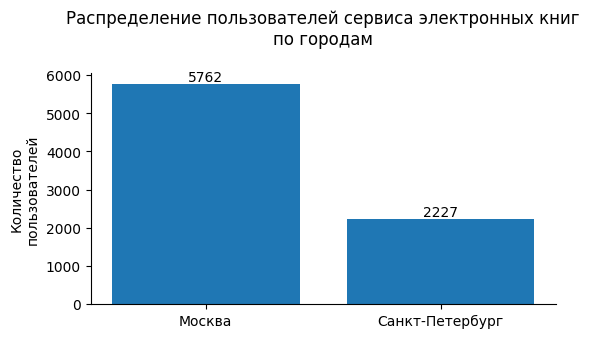

In [35]:
# Задаем область и оси
fig, ax = plt.subplots(figsize=(6, 3))

# Строим столбчатую диаграмму
ax.bar(knigi_cities.index, knigi_cities['puid'])

# Задаем название и подписываем ось
ax.set_title('Распределение пользователей сервиса электронных книг\nпо городам\n')
ax.set_ylabel('Количество\nпользователей')

# Убираем границы
ax.spines[['top', 'right']].set_visible(False)

# Подписываем бары
plt.bar_label(ax.containers[0])

# Выводим график
plt.show()

Количество пользователей из Москвы в 2.6 раза превышает количества пользователей из Санкт-Петербурга. При общей численности населения: Москва - 13.1 млн. человек, Санкт-Петербург - 5.6 млн, в выборку вошло по 0.004% от каждого города. При этом стоит учесть, что в меньшей выборке (в выборке Санкт-Петербурга) наличие выбросов окажет более сильное влияние на среднее значение.

Поскольку важно сохранить данные, которые могут показать особенность поведения пользователей в разных городах, изучать выбросы и чистить данные от выбросов будем отдельно для каждого города.

### Изучение времени активности пользователей из Москвы

In [20]:
# Данные активности пользователей из Москвы
moscow = knigi_cleaned[knigi_cleaned['city'] == 'Москва']

In [21]:
moscow['hours'].describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.95, 0.99])

count    5762.000000
mean       11.277426
std        37.584876
min         0.001390
5%          0.004444
10%         0.010586
25%         0.087041
50%         1.038671
75%         6.340268
95%        56.733230
99%       163.444129
max       857.209373
Name: hours, dtype: float64

In [22]:
# Рассчитаем квартили
qr_1 = np.percentile(moscow['hours'], 25)
qr_3 = np.percentile(moscow['hours'], 75)

# Межквартильный размах
iqr = qr_3 - qr_1

# Границы выбросов
lower_lim = qr_1 - 1.5 * iqr if qr_1 - 1.5 * iqr >=0 else moscow['hours'].min()
upper_lim = qr_3 + 1.5 * iqr

print(f'Нижняя граница: {lower_lim:.6f}, верхняя граница: {upper_lim:.2f}')

Нижняя граница: 0.001390, верхняя граница: 15.72


* Среднее 11.28 более чем в 10 раз превышает медиану 1.04, т.е. в данных есть пользователи с очень большим временем активности.
* Стандартное отклонение 38.58 больше среднего в 3.4 раза, что говорит о сильном разбросе данных.
* 5% пользователей с временем активности от 5 до 16 секунд
* 5% - с временем активности от 56.7 часов до 857.21 часов
75% - пользовались приложением не более 6.3 часа за весь период

### Изучение времени активности пользователей из Санкт-Петербурга

In [23]:
# Данные активности пользователей из Санкт-Петербурга
petersburg = knigi_cleaned[knigi_cleaned['city'] == 'Санкт-Петербург']

In [24]:
petersburg['hours'].describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.95, 0.99])

count    2227.000000
mean       11.664000
std        40.474845
min         0.001406
5%          0.003980
10%         0.008536
25%         0.090325
50%         0.994091
75%         6.483458
95%        57.166683
99%       150.913682
max       978.764775
Name: hours, dtype: float64

In [25]:
# Рассчитаем квартили
qr_1 = np.percentile(petersburg['hours'], 25)
qr_3 = np.percentile(petersburg['hours'], 75)

# Межквартильный размах
iqr = qr_3 - qr_1

# Границы выбросов
lower_lim = qr_1 - 1.5 * iqr if qr_1 - 1.5 * iqr >=0 else petersburg['hours'].min()
upper_lim = qr_3 + 1.5 * iqr

print(f'Нижняя граница: {lower_lim:.6f}, верхняя граница: {upper_lim:.2f}')

Нижняя граница: 0.001406, верхняя граница: 16.07


* Среднее 11.66 более чем в 10 раз превышает медиану 0.99, т.е. в данных есть пользователи с очень большим временем активности.
* Стандартное отклонение 40.47 больше среднего в 3.5 раза, что говорит о сильном разбросе данных.
* 5% пользователей с временем активности от 5 до 14 секунд
* 5% - с временем активности от 57.1 часов до 978.76 часов
75% - пользовались приложением не более 6.5 часа за весь период

### Распределение времени активности пользователей

Между группами пользователей из Москвы и Санкт-Петербурга не наблюдаются различия в характере выбросов. Очистим данные от выбросов до распределени их на группы.

In [26]:
knigi_cleaned['hours'].describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.8, 0.9, 0.95, 0.99])

count    7989.000000
mean       11.385187
std        38.410166
min         0.001390
5%          0.004189
10%         0.010023
25%         0.088611
50%         1.026667
75%         6.418036
80%         9.415890
90%        26.511388
95%        57.005551
99%       160.745554
max       978.764775
Name: hours, dtype: float64

* Среднее 11.39 существенно превышает медиану 1.03, т.е. в данных есть пользователи с очень большим временем активности.
* Стандартное отклонение 38.41 больше среднего в 3.4 раза, что говорит о сильном разбросе данных.

* 5% пользователей с временем активности от 5 до 15 секунд
* 5% - с временем активности от 57 часов до 979 часов
* 75% - пользовались приложением не более 6.4 часа за весь период

Для анализа типичного поведения пользователей рассчитаем границы выбросов:

In [27]:
# Рассчитаем квартили
qr_1 = np.percentile(knigi_cleaned['hours'], 25)
qr_3 = np.percentile(knigi_cleaned['hours'], 75)

# Межквартильный размах
iqr = qr_3 - qr_1

# Границы выбросов
lower_outlier = qr_1 - 1.5 * iqr if qr_1 - 1.5 * iqr >=0 else knigi_cleaned['hours'].min()
upper_outlier = qr_3 + 1.5 * iqr

print(f'Нижняя граница: {lower_outlier:.6f}, верхняя граница: {upper_outlier:.2f}')

Нижняя граница: 0.001390, верхняя граница: 15.91


Сохраним в `knigi_no_outliers` данные без выбросов и посмотрим на статистику:

In [28]:
# Фильтруем и сохраняем данные 
knigi_no_outliers = knigi_cleaned[(knigi_cleaned['hours'] >= lower_outlier) &\
                                                (knigi_cleaned['hours'] <= upper_outlier)]

# Выводим статистику
knigi_no_outliers['hours'].describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.95])

count    6823.000000
mean        2.215312
std         3.409183
min         0.001390
5%          0.003635
10%         0.008056
25%         0.052260
50%         0.559490
75%         2.905103
95%        10.376336
max        15.889759
Name: hours, dtype: float64

* После удаления выбросов объем данных сократился на 14.6% (удалено 1166 записей). 
* Среднее время активности сократилось с  11,39 часов до 2,2 часов
* Стандартное отклонение - с 38,4 до 3,4.
* Медиана по новым данным составляет 0,56 час., то есть 50% пользователей проводят в приложении не более 34 мин.
* 5% пользователей с временем активности от 5 до 13 секунд
* 5% - с временем активности от 10,38 часов до 15,89 часов
* 25% самых активных пользователей провели в приложении более 2,9 часов

Построим график распределения времени активности всех пользователей за наблюдаемый период:

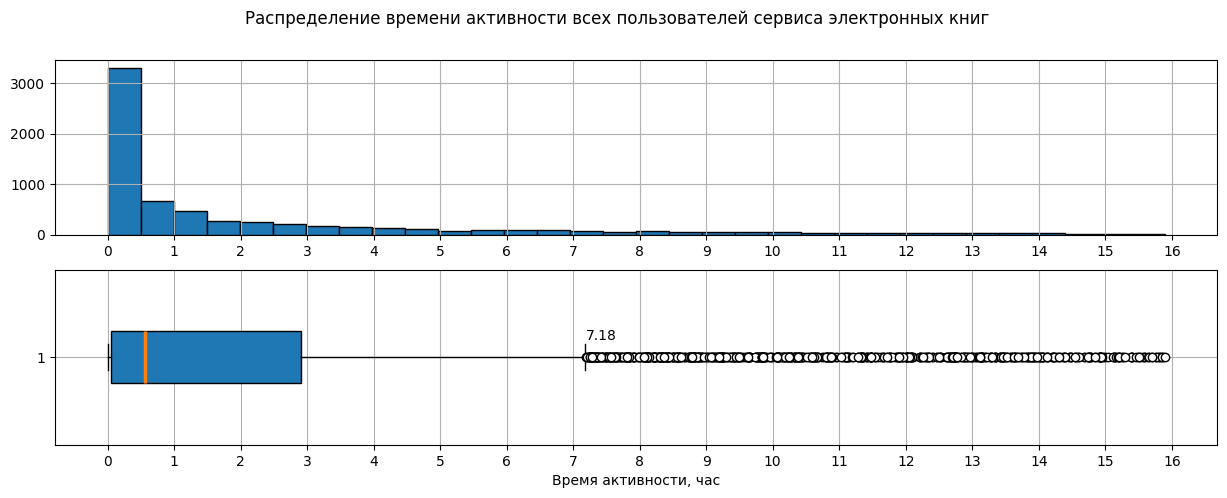

In [29]:
# Подготовим данные:
# Рассчитаем квартили
qr_1 = np.percentile(knigi_no_outliers['hours'], 25)
qr_3 = np.percentile(knigi_no_outliers['hours'], 75)
# Межквартильный размах
iqr = qr_3 - qr_1
# Правая граница выбросов
upper_outlier = qr_3 + 1.5 * iqr


# Задаем размер фигуры
plt.figure(figsize=(15, 5))

# Задаем название
plt.suptitle('Распределение времени активности всех пользователей сервиса электронных книг\n')

# Строим первый график: гистограмму
plt.subplot(2, 1, 1)
plt.hist(knigi_no_outliers['hours'], bins=32,  edgecolor = 'black')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
plt.grid()

# Строим второй график: диаграмму размаха
plt.subplot(2, 1, 2)
plt.boxplot(knigi_no_outliers['hours'], vert=False, widths=0.3,
            flierprops=dict(markerfacecolor='w'),
            patch_artist = True, boxprops = dict(facecolor = 'tab:blue'), 
            medianprops = dict(linewidth = 2.5))
plt.xlabel('Время активности, час')
plt.ylabel(' ')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
plt.grid()
plt.text(upper_outlier, 1.1, f'{upper_outlier:.2f}')

# Выводим графики
plt.show()


Типичный пользователь согласно данным использовал приложение от 3,14 минут (25% перцентиль) до 2,91 часов (75% перцентиль).  Самые активные пользователи читали и слушали книги в приложении более 7,18 часов, при этом суперактивные (95% перцентиль) более 10,38 часов.

Посмотрим как время активности пользователей зависит от геолокации:

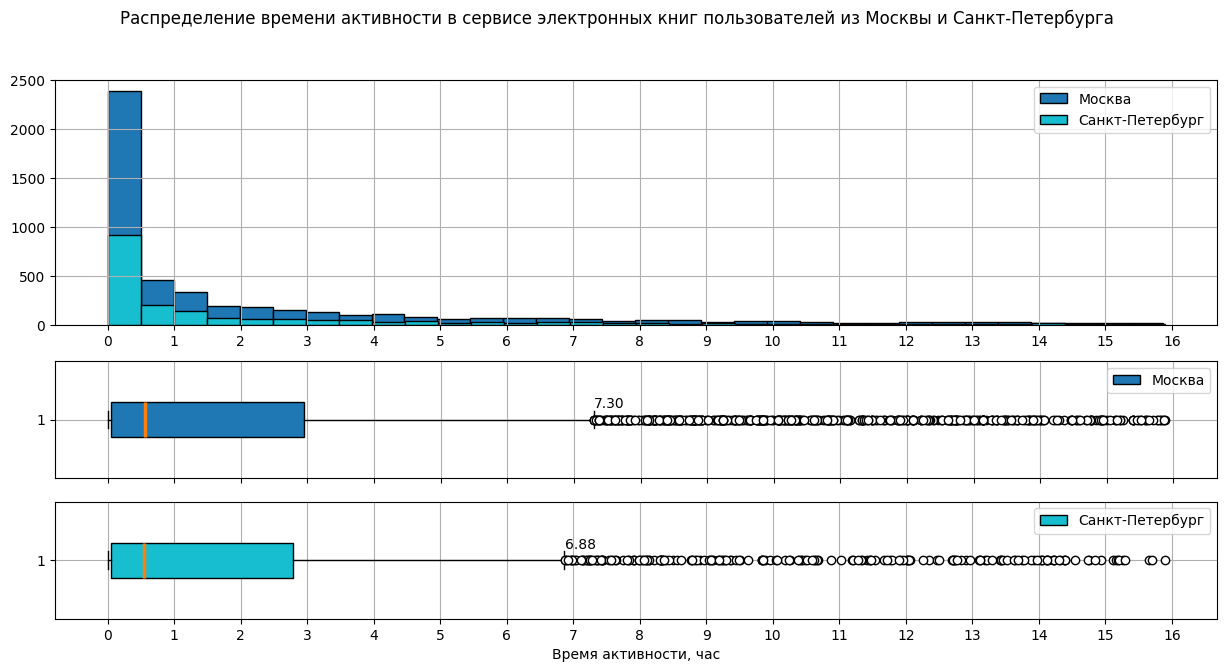

In [30]:
# Готовим данные:

moscow_no_outliers = knigi_no_outliers['hours'][knigi_no_outliers['city'] == 'Москва']
petersburg_no_outliers = knigi_no_outliers['hours'][knigi_no_outliers['city'] == 'Санкт-Петербург']

# Данные для подписей границ выбросов:
# Рассчитаем квартили
moscow_qr_1 = np.percentile(moscow_no_outliers, 25)
moscow_qr_3 = np.percentile(moscow_no_outliers, 75)
petersburg_qr_1 = np.percentile(petersburg_no_outliers, 25)
petersburg_qr_3 = np.percentile(petersburg_no_outliers, 75)
# Межквартильный размах
moscow_iqr = moscow_qr_3 - moscow_qr_1
petersburg_iqr = petersburg_qr_3 - petersburg_qr_1
# Правая граница выбросов
moscow_upper_outlier = moscow_qr_3 + 1.5 * moscow_iqr
petersburg_upper_outlier = petersburg_qr_3 + 1.5 * petersburg_iqr

#Задаем размер фигуры
plt.figure(figsize=(15, 7))
# Добавляем название
plt.suptitle('Распределение времени активности в сервисе электронных книг пользователей из Москвы и Санкт-Петербурга')

# Строим первый график: гистогрумма
plt.subplot(2,1,1)
plt.hist(moscow_no_outliers, bins=32, label='Москва', edgecolor = 'black')
plt.hist(petersburg_no_outliers, bins=32, label='Санкт-Петербург', color='tab:cyan', edgecolor = 'black')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
plt.legend()
plt.grid()

# Строим второй график: диаграмму размаха
plt.subplot(4,1,3)
plt.boxplot(moscow_no_outliers, vert=False, widths=0.3, label='Москва', flierprops=dict(markerfacecolor='w'),
            patch_artist = True, boxprops = dict(facecolor = 'tab:blue'),  medianprops = dict(linewidth = 2.5))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], color='w')
plt.text(moscow_upper_outlier, 1.1, f'{moscow_upper_outlier:.2f}')
plt.legend()
plt.grid()

# Строим третий график: диаграмму размаха
plt.subplot(4,1, 4)
plt.boxplot(petersburg_no_outliers, vert=False,  widths=0.3,  label='Санкт-Петербург', flierprops=dict(markerfacecolor='w'),
            patch_artist = True, boxprops = dict(facecolor = 'tab:cyan'),  medianprops = dict(linewidth = 2.5))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
plt.text(petersburg_upper_outlier, 1.1, f'{petersburg_upper_outlier:.2f}')
plt.legend()
plt.grid()
plt.xlabel('Время активности, час')

# Выводим графики
plt.show()

### Промежуточный вывод

После очистки данных от выбросов получаем следующее: 

In [31]:
moscow_no_outliers = knigi_no_outliers['hours'][knigi_no_outliers['city'] == 'Москва']
petersburg_no_outliers = knigi_no_outliers['hours'][knigi_no_outliers['city'] == 'Санкт-Петербург']

print(f'Количество пользователей из Москвы: {moscow_no_outliers.shape[0]}')
print(f'Количество пользователей из Санкт-Петербурга: {petersburg_no_outliers.shape[0]}')
print(f'Пользователей из Москвы в {round(moscow_no_outliers.shape[0] / petersburg_no_outliers.shape[0], 2)} раза больше, чем пользователей из Санкт-Петербурга')
print('------------')

print(f'Среднее значение времени активности пользователй из Москвы: {moscow_no_outliers.mean().round(2)} час.')
print(f'Среднее значение времени активности пользователй из Санкт-Петербурга: {petersburg_no_outliers.mean().round(2)} час.')

delta_mean = moscow_no_outliers.mean() - petersburg_no_outliers.mean()
print(f'Среднее значение для Москвы больше среднего значения для Санкт-Петербурга на: {delta_mean.round(3)} час., то есть на {(60*delta_mean).round(2)} мин.')
print('------------')

print(f'Медиана времени активности пользователй из Москвы: {round(moscow_no_outliers.median(), 2)} час.')
print(f'Медиана времени активности пользователй из Санкт-Петербурга: {round(petersburg_no_outliers.median(), 2)} час.')

delta_median = moscow_no_outliers.median() - petersburg_no_outliers.median()
print(f'Медиана времени активности пользователей из Москвы больше медианы для Санкт-Петербурга на: {round(delta_median, 3)} час., то есть на {round(60*delta_median, 2)} мин.')


Количество пользователей из Москвы: 4937
Количество пользователей из Санкт-Петербурга: 1886
Пользователей из Москвы в 2.62 раза больше, чем пользователей из Санкт-Петербурга
------------
Среднее значение времени активности пользователй из Москвы: 2.24 час.
Среднее значение времени активности пользователй из Санкт-Петербурга: 2.15 час.
Среднее значение для Москвы больше среднего значения для Санкт-Петербурга на: 0.094 час., то есть на 5.61 мин.
------------
Медиана времени активности пользователй из Москвы: 0.57 час.
Медиана времени активности пользователй из Санкт-Петербурга: 0.55 час.
Медиана времени активности пользователей из Москвы больше медианы для Санкт-Петербурга на: 0.016 час., то есть на 0.99 мин.


Пользователи из Москвы использовали приложение в среднем на 5.61 мин дольше, чем пользователи из Санкт-Петербурга. Наличие активных пользователей в обеих группах приводит к тому, что средние значения в 2 с лишним раза превышают медианные. Средние значения не отражают поведение большинства пользователей. Сравнение же медианных значений показывает, что пользователи из Москвы также более активны, однако разница между группами существенно ниже - менее минуты. Такая разница может не иметь практической значимости.

## Проверка гипотезы в Python

Имеем две группы: группа А - пользователи из Москвы, группа В - пользователи из Санкт-Петербурга.  
1. Объем данных в группах достаточен, чтобы, опираясь на ЦПТ, сделать вывод  о нормальности распределения выборочных средних. Однако распределения исходных выборок имеют тяжелые хвосты, что может нарушить действие ЦПТ.
2. Анализ диаграмм распределения показывает схожесть межквартильных размахов и длины усов, что визуально подтверждает равенство выборочных дисперсий. Однако, учитывая разный размер групп, группа В будет более чувствительна к выбросам, что может искажать дисперсию.
3. Гистограммы распределения двух групп имеют схожую форму, но различаются масштабом из-за разного объема данных в группах. Группы сформированы из непересекающихся множеств пользователей, что обеспечивает независимость выборок. Все наблюдения внутри групп являются независимыми в силу отсутствия повторных наблюдений у одного и того же пользователя.

* Сформулируем гипотезу: пользователи из Санкт-Петербурга проводят в среднем меньше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. В качестве основной метрики выбираем: среднее время (в часах) активности пользователей в приложении.  

Обозначим за μA и μB - среднее значение метрикий для группах A (Москва) и B (Санкт-Петербург). Тогда гипотезы будут выглядеть так:  
• H0: μA <= μB  
• H1: μA > μB  
  
Применим t-тест Уэлча на случай, что дисперсии все-таки искажены выбросами:

In [32]:
# Выборки для группы А и В
metric_a = moscow_no_outliers
metric_b = petersburg_no_outliers

# Уровень значимости
alpha = 0.05

# Применяем тест
stat_ttest, p_value_ttest = ttest_ind(metric_a, metric_b, equal_var=False, alternative='greater') 

if p_value_ttest > alpha:
    print(f'pvalue={p_value_ttest} >= {alpha}')
    print('Нет оснований отвергнуть нулевую гипотезу. Статистически значимых различий не обнаружено.')
else:
    print(f'pvalue={p_value_ttest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.15388550203128662 >= 0.05
Нет оснований отвергнуть нулевую гипотезу. Статистически значимых различий не обнаружено.


В среднем пользовали из Москвы не проводят больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Санкт-Петербурга.

* Выше мы отметили, что распределения исходных выборок имеют тяжелые хвосты, что может нарушить действие ЦПТ. Исключим влияние высоких значений на результаты t-теста. Проверим различаются ли распределения с помощью нечувствительного к выбросам теста Манна — Уитни.  

Проверим, что распределение времени активности пользователей из Москвы правее распределения для пользователей из Санкт-Петербурга.  

Обозначим за {XA,XВ} распределение времени активности пользователей в группах A и B соответственно. Тогда гипотеза будет выглядеть так:  
• H0: Dist(XA) <= Dist(XB)  
• H1: Dist(XA) > Dist(XB)

In [33]:
# Применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    metric_a, 
    metric_b, 
    alternative='greater'
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нет оснований отвергнуть нулевую гипотезу. Статистически значимых различий не обнаружено.')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.13582959381509074 > 0.05
Нет оснований отвергнуть нулевую гипотезу. Статистически значимых различий не обнаружено.


Распределение времени активности пользователей из Москвы не находится правее распределения активности пользователей из Санкт-Петербурга.

* Рассчитаем фактическую мощность теста:

In [34]:
# Подготовим данные
# Объем групп
n_a = moscow_no_outliers.shape[0]
n_b = petersburg_no_outliers.shape[0]

# Стандартное отклонение групп
std_a = moscow_no_outliers.std()
std_b = petersburg_no_outliers.std()
print('Стандартное отклонение группы А: ', std_a)
print('Стандартное отклонение группы B: ', std_b)

# Cредние значения групп
mean_a = moscow_no_outliers.mean()
mean_b = petersburg_no_outliers.mean()

# Считаем объединенное стандартное отклонение
pooled_std = np.sqrt(((n_a-1)*std_a**2 + (n_b-1)*std_b**2) / (n_a+n_b-2))

# Считаем размер эффекта
cohens_d = abs(mean_a - mean_b) / pooled_std
print('Размер эффекта: ', cohens_d)

# Считаем мощность теста
power = tt_ind_solve_power(
    effect_size=cohens_d,
    nobs1=n_a,        
    alpha=0.05,       
    ratio=n_b/n_a,        
    alternative='larger'  
)
print(f"Мощность теста: {power:.2%}")  

Стандартное отклонение группы А:  3.4219964268265537
Стандартное отклонение группы B:  3.3753748290322836
Размер эффекта:  0.027443984501491457
Мощность теста: 26.40%


## Аналитическая записка

В качестве критерия для проверки гипотезы был выбран t-тест Уэлча и уровень статистической значимости 5%. Тест показала, что pvalue=0.1539 превышает уровень статистической значимости, то есть не было обнаружено статистически значимых различий между среднем временем активности пользователей из Москвы и Санкт-Петербурга. Это означает, что наблюдаемая разница среднего времени активности пользователей могла возникнуть случайно из-за вариативности данных.
Для исключения возможного влияния выбросов на результаты t-теста, распределение времени активности пользователей групп А и В были протестированы с помощью теста Манна — Уитни. Тест не выявил значимых различий в распределении данных рассматриваемых групп.

Отметим, что на результат теста могло повлиять соотношение размеров групп, высокая дисперсия и слишком маленький эффект, которые снизили мощность теста и способность обнаружить эффект.

----